In [2]:
import os
from os.path import join
import pandas as pd
import re

# Creating dataframe with data

In [ ]:
!unzip '/content/sampled_texts.zip'

In [4]:
folder_path = '/content/sampled_texts'

In [5]:
# strorage of all texts
data = {
    'headings': [],
    'text': []
}

for file_name in os.listdir(folder_path):
  file_path = join(folder_path, file_name)

  with open(file_path, 'r') as f:
    heading, text = f.read().split('\n\n')
    heading = re.sub(r'Topic:\s', '', heading)
    text = re.sub(r'Text:\s', '', text)

  data['headings'].append(heading)
  data['text'].append(text)

In [6]:
df = pd.DataFrame(data)

In [7]:
df

,headings,text
0,Oil prices up on Yukos woes,NEW YORK -- Oil prices broke above \$46 yester...
1,Brazilian Soldier Wounded in Haiti Unrest,&lt;p&gt;&lt;/p&gt;&lt;p&gt; By Joseph Guyler ...
2,Colombian Military Kills Militia Leader,A former U.S.-trained Colombian army officer w...
3,Study May ID Source of Vioxx Problem,"Nov. 11, 2004 -- A private research team claim..."
4,Thaksin vows #39;iron fist #39; against rebel...,BANGKOK Prime Minister Thaksin Shinawatra head...
...,...,...
195,Yankees Seek to Keep Pitcher Jon Lieber (AP),AP - After watching their starting pitchers st...
196,Ex-NASA Worker Pleads Innocent of Fake Inspect...,A fired NASA safety inspector accused of falsi...
197,Jeremy Warner #39;s Outlook: Is anyone safe as...,Is no one safe from Eliot Spitzer #39;s accusi...
198,US rocket team halfway to winning \$10-million...,"MOJAVE, CALIF. - A privately built and operate..."


# Texts preprocessing

In [8]:
!pip install nltk

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
def removeStopwords(text):
    '''Function removes stopwords and punctuation'''
    words = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    no_stopwords_text = ' '.join(filtered_words)
    no_punkt_text = ' '.join(re.findall(r'\w+', no_stopwords_text))
    return no_punkt_text

def lemmatization(text):
    '''Function lemmatizes words and breaks sentences into tokens'''
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lWords = [lemmatizer.lemmatize(word) for word in words]
    lText = ' '.join(lWords)
    return lText

def preprocess(text):
    '''Function encapsulates two previous functions and preprocesses text'''
    text = re.sub(r'(&lt;p&gt;)|(&lt;/p&gt;)', '', text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text

In [11]:
df['text'] = df['text'].apply(preprocess)
df['headings'] = df['headings'].apply(preprocess)

# Word embeddings

In [12]:
!pip install gensim

In [13]:
from gensim.models import Word2Vec
import numpy as np

In [14]:
# tokenize texts
df['text_tokenized'] = df['text'].apply(word_tokenize)

In [15]:
# word2vec model for text vectorization
model = Word2Vec(sentences=df['text_tokenized'], vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0
    for word in words:
        if word in vocabulary:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

word_vectors = []
for words in df['text_tokenized']:
    word_vectors.append(average_word_vectors(words, model, model.wv.index_to_key, 100))

# Clustering

In [16]:
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [17]:
# decrease words embeddings to array with only 2 elements
pca = PCA(n_components=2)
X_pca = pca.fit_transform(word_vectors)

X_pca.shape

(200, 2)

In [18]:
# X - sample to define the number of clusters
# one_x - smaller sample for classification
X, one_x =  X_pca[:199], X_pca[199:]

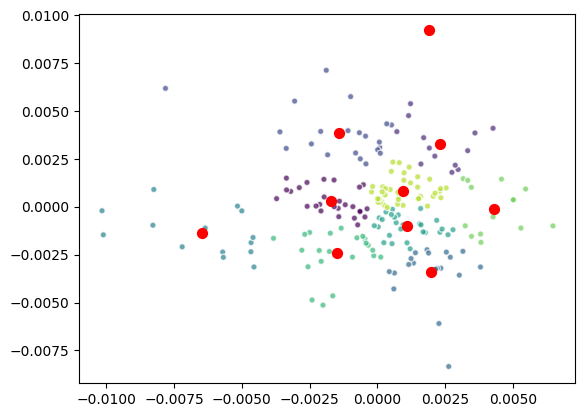

number of clusters: 10
score: 0.3074592031815303


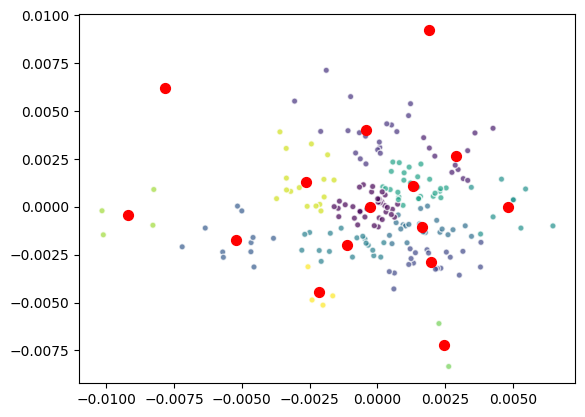

number of clusters: 15
score: 0.3307191136979663


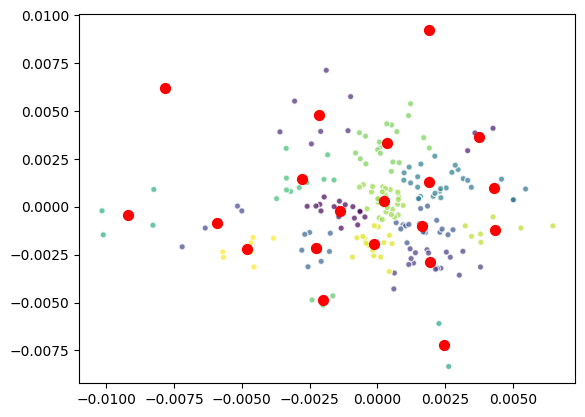

number of clusters: 20
score: 0.3624269825024691


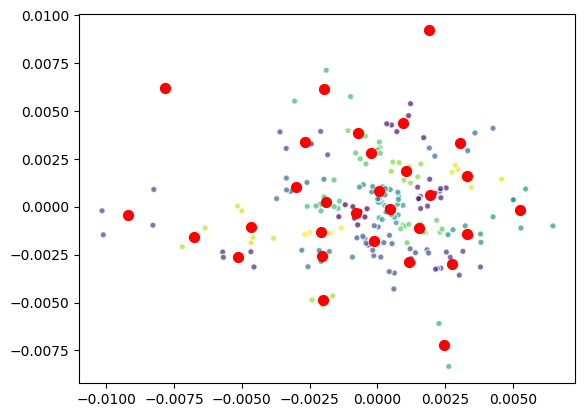

number of clusters: 30
score: 0.3649774458040316


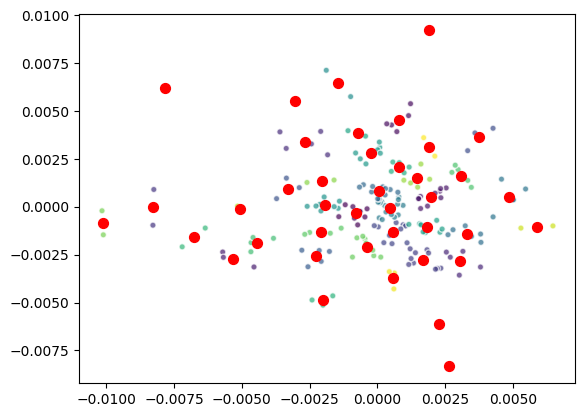

number of clusters: 40
score: 0.37402653010587356


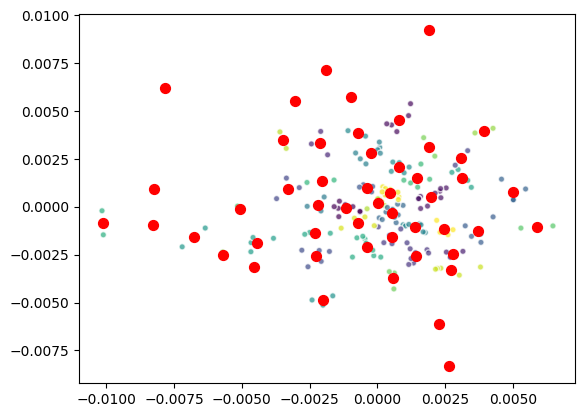

number of clusters: 50
score: 0.37449138925358055


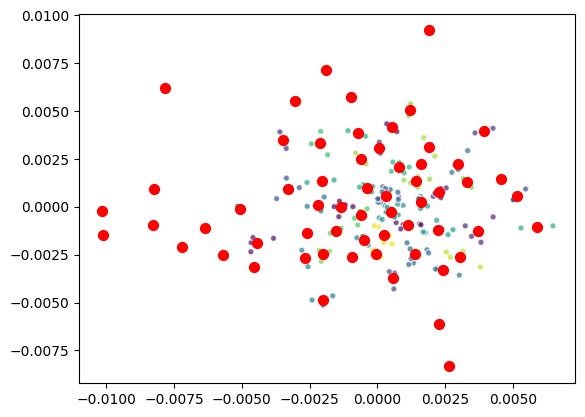

number of clusters: 60
score: 0.39105349116506816


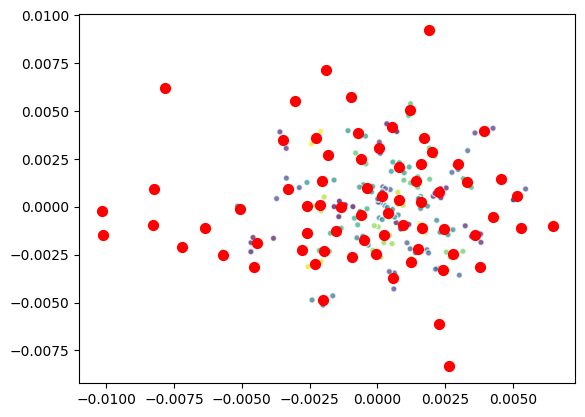

number of clusters: 70
score: 0.3831195311863763


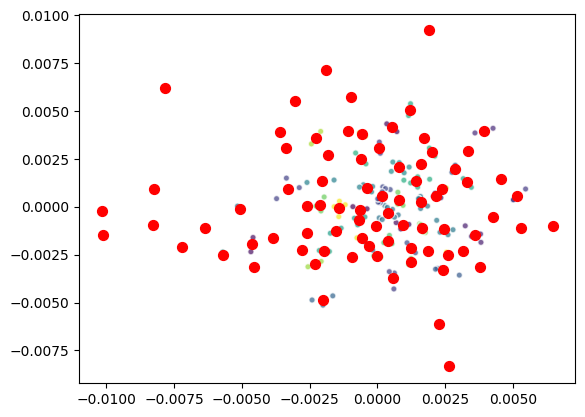

number of clusters: 80
score: 0.3641619903341835


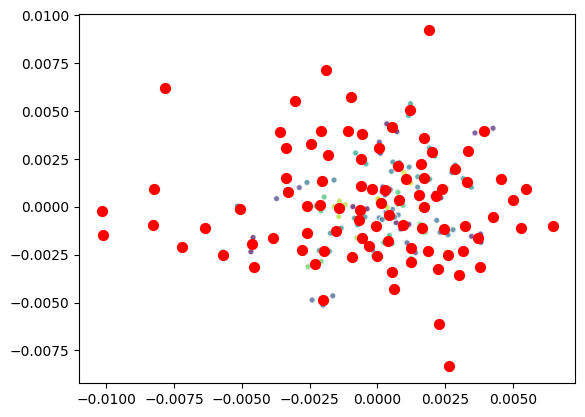

number of clusters: 90
score: 0.36833747081969653


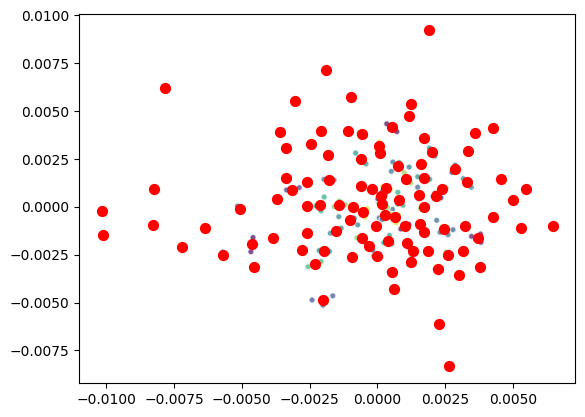

number of clusters: 100
score: 0.3248398772800056


In [19]:
# set of numbers to find out appropriate amount of cluters with
# highest silhouette score
nClusters = [10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
silhouetteScore = defaultdict(float)
groupCount = defaultdict(pd.DataFrame)

# highest score and optimal number of clusters
best_score = 0
best_n = 0
for i in nClusters:
    # fit model
    kmeans = KMeans(n_clusters=i, random_state=69)
    kmeans.fit(X)

    # silhouette score
    clusterLabels = kmeans.labels_
    silhouetteScore[i] = silhouette_score(X, clusterLabels)

    clusterCount = np.bincount(clusterLabels)
    tempDict = {}
    for index, count in enumerate(clusterCount):
        tempDict[index] = count
    tempDict = pd.DataFrame.from_dict(tempDict, orient='index', columns=['count'])
    groupCount[i] = tempDict

    # vizualize plot with possible number of clusters
    plt.scatter(X[:, 0], X[:, 1], c=clusterLabels, cmap='viridis', s=20, alpha=0.7, edgecolors='w')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='o', c='red', s=50)
    plt.show()

    if silhouetteScore[i] > best_score:
      best_score, best_n = silhouetteScore[i], i

    print(f'number of clusters: {i}')
    print(f'score: {silhouetteScore[i]}')


In [20]:
best_n, best_score

(60, 0.39105349116506816)

# Clustering a new document

In [21]:
from sklearn.neighbors import NearestNeighbors

In [22]:
# initialize clustering model with the best parameters
kmeans_best = KMeans(n_clusters=best_n, random_state=69)
kmeans_best.fit(X)

cluster_map = pd.DataFrame()
cluster_map['cluster'] = kmeans_best.labels_

In [25]:
# initialize classification model
nn_model = NearestNeighbors()
nn_model.fit(X)
# find nearest neighbors
res = nn_model.kneighbors(one_x, return_distance=False)

In [26]:
# define cluster for a one_x sample
for ids in res:
  # get cluster for each nearest neighbor
  clusters = [cluster_map.iloc[id]['cluster'] for id in ids]
  # the most frequent cluster among nearest points is the cluster for the given text
  nearest_cluster = max(clusters, key=clusters.count)
  print(nearest_cluster)

14
